<a href="https://colab.research.google.com/github/lqiang67/rectified-flow/blob/main/examples/inference_flux_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lqiang67/rectified-flow.git
%cd rectified-flow/

In [ ]:
# Optional: Login to Hugging Face if you haven't downloaded the checkpoint yet.
# Make sure you select "Read access to contents of all public gated repos you can access" when creating the token
from huggingface_hub import login
login(token="YOUR_HUGGINGFACE_TOKEN") # Fill your huggingface token here

# Optional: Specify custom cache directories (modify paths as needed)
import os
os.environ['HF_HOME'] = './'
os.environ['HF_HUB_CACHE'] = './'
os.environ['HF_DATASETS_CACHE'] = './'

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import sys
import os

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms
from IPython.display import clear_output

DTYPE = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=DTYPE)
pipe.to(device)
print(f"Loaded pipeline to device {device}")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pipeline to device cuda


In [2]:
from rectified_flow.models.flux_dev import FluxWrapper
from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import set_seed

set_seed(0)

height = 1025
width = 1025

flux_model = FluxWrapper(
    pipeline=pipe,
    height=height,
    width=width,
    dtype=DTYPE,
    device=device,
)

rectified_flow = RectifiedFlow(
    data_shape=flux_model.dit_latent_shape,
    velocity_field=flux_model,
    interp="straight",
    device=device,
	dtype=DTYPE,
)

/root/rectified-flow/rectified_flow/models/flux_dev.py:137: UserWarning: Height and width must be divisible by 16. Adjusted to 1024x1024.
  warnings.warn(


In [3]:
time_grid = flux_model.prepare_time_grid(num_steps=50)
print(f"time_grid: {time_grid}")	

def print_time_callback(sampler): # demo callback function, e.g. one-step prediction
    """A callback function to print the current time t, refreshing the Jupyter Notebook output."""
    clear_output(wait=True)
    print(f"Current time: {sampler.t:.4f}")
    
my_callback = [print_time_callback]

time_grid: [0.0, 0.006420493125915527, 0.013021409511566162, 0.01981043815612793, 0.026795804500579834, 0.03398615121841431, 0.04139059782028198, 0.0490187406539917, 0.05688118934631348, 0.06498855352401733, 0.0733526349067688, 0.08198583126068115, 0.09090131521224976, 0.1001131534576416, 0.10963630676269531, 0.11948692798614502, 0.12968218326568604, 0.14024043083190918, 0.15118151903152466, 0.16252654790878296, 0.17429840564727783, 0.1865214705467224, 0.19922232627868652, 0.2124294638633728, 0.22617393732070923, 0.24048906564712524, 0.2554112672805786, 0.2709798216819763, 0.2872377038002014, 0.30423182249069214, 0.32201331853866577, 0.3406381607055664, 0.36016780138015747, 0.38066989183425903, 0.40221887826919556, 0.42489707469940186, 0.44879549741744995, 0.47401559352874756, 0.5006698668003082, 0.5288844406604767, 0.5588002800941467, 0.5905761122703552, 0.6243909895420074, 0.6604477167129517, 0.6989767849445343, 0.7402416169643402, 0.7845441848039627, 0.832232877612114, 0.88371122628

In [4]:
from rectified_flow.samplers import rf_samplers_dict

for sampler_name, sampler_class in rf_samplers_dict.items():
	print(f"Sampler: {sampler_name}, class: {sampler_class}")

Sampler: euler, class: <class 'rectified_flow.samplers.euler_sampler.EulerSampler'>
Sampler: curved_euler, class: <class 'rectified_flow.samplers.curved_euler_sampler.CurvedEulerSampler'>
Sampler: noise_refresh, class: <class 'rectified_flow.samplers.noise_refresh_sampler.NoiseRefreshSampler'>
Sampler: overshooting, class: <class 'rectified_flow.samplers.overshooting_sampler.OverShootingSampler'>
Sampler: sde, class: <class 'rectified_flow.samplers.sde_sampler.SDESampler'>
Sampler: curved_sde, class: <class 'rectified_flow.samplers.stochastic_curved_euler_sampler.StochasticCurvedEulerSampler'>
Sampler: stochastic_curved_euler, class: <class 'rectified_flow.samplers.stochastic_curved_euler_sampler.StochasticCurvedEulerSampler'>


## Euler Sampler

$$
X_{t+1} = X_{t} + \Delta t \cdot v_{\theta}(X_t, t)
$$

Current time: 1.0000
torch.Size([1, 4096, 64])


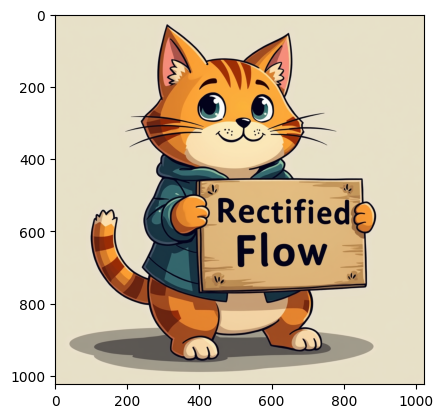

In [5]:
from rectified_flow.samplers import EulerSampler

euler_sampler = EulerSampler(
    rectified_flow=rectified_flow,
    callbacks=my_callback,
    time_grid=time_grid,
    num_samples=1,
)

euler_sampler.sample_loop(
    seed=0,
    prompt="A photo of a cat holding a sign, say 'Rectified Flow'",
    guidance_scale=3.5,
)

x_1 = euler_sampler.trajectories[-1]
print(x_1.shape)

img = flux_model.decode(x_1)
plt.imshow(img)

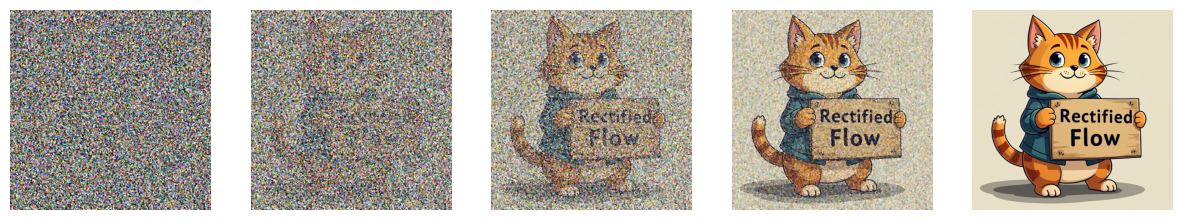

In [6]:
N = 5
plt.figure(figsize=(3*N, 3))
for i, idx in enumerate(torch.linspace(0, len(euler_sampler.trajectories)-1, N).int()):
    plt.subplot(1, N, i+1)
    img = flux_model.decode(euler_sampler.trajectories[idx])
    plt.imshow(img)
    plt.axis("off")

## SDE Sampler

Current time: 1.0000


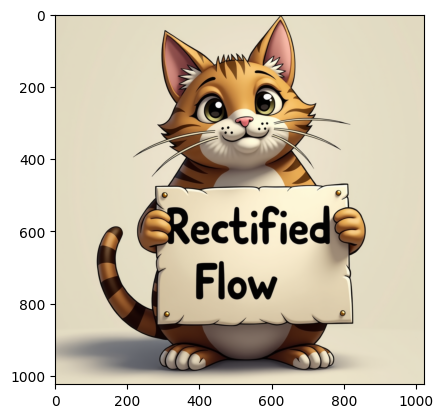

In [7]:
from rectified_flow.samplers import SDESampler

sde_sampler = SDESampler(
    rectified_flow=rectified_flow,
	callbacks=my_callback,
	time_grid=time_grid,
    num_samples=1,
    noise_scale=10.0,
    noise_decay_rate=1.0,
    noise_method="stable",
    ode_method="curved",
)

sde_sampler.sample_loop(
    seed=0,
	prompt="A photo of a cat holding a sign, say 'Rectified Flow'",
	guidance_scale=3.5,
)

x_1 = sde_sampler.trajectories[-1]

img = flux_model.decode(x_1)

plt.imshow(img)

## Noise Refresh Sampler

Current time: 1.0000
torch.Size([1, 4096, 64])


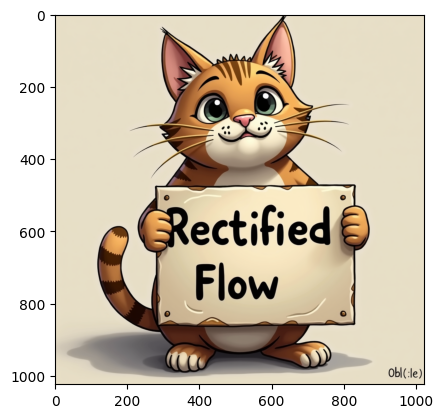

In [8]:
from rectified_flow.samplers import NoiseRefreshSampler

noise_refresh_sampler = NoiseRefreshSampler(
    rectified_flow=rectified_flow,
    callbacks=my_callback,
    num_samples=1,
    time_grid=time_grid,
    noise_replacement_rate=lambda t: 0.3,
)

noise_refresh_sampler.sample_loop(
    seed=0,
    prompt="A photo of a cat holding a sign, say 'Rectified Flow'",
    guidance_scale=3.5,
)

x_1 = noise_refresh_sampler.trajectories[-1]
print(x_1.shape)

img = flux_model.decode(x_1)
plt.imshow(img)

Current time: 1.0000
torch.Size([1, 4096, 64])


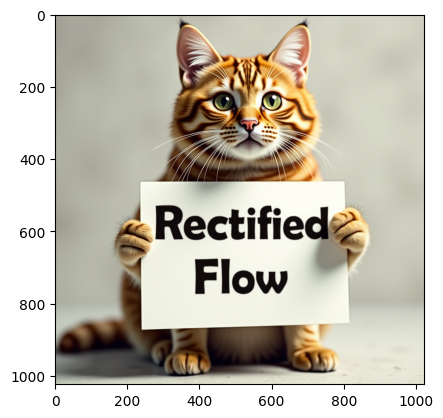

In [9]:
from rectified_flow.samplers import OverShootingSampler

overshoot_sampler = OverShootingSampler(
    rectified_flow=rectified_flow,
    callbacks=my_callback,
    time_grid=time_grid,
    num_samples=1,
)

overshoot_sampler.sample_loop(
    seed=0,
    prompt="A photo of a cat holding a sign, say 'Rectified Flow'",
    guidance_scale=3.5,
)

x_1 = overshoot_sampler.trajectories[-1]
print(x_1.shape)

img = flux_model.decode(x_1)
plt.imshow(img)